In [3]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
%matplotlib inline
#%pylab inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import athena4_read as ath

# 1. read a sample vtk data of athena4.2 (run x1y4z4r64pm1)

In [2]:
t,x,y,z,data=ath.vtk('Unstra.0080.vtk')

time =  2481.862
face_dimensions =  [65, 257, 257]
-5.000000e-01 -2.000000e+00 -2.000000e+00
box_origin =  [-0.5, -2.0, -2.0]
1.562500e-02 1.562500e-02 1.562500e-02
grid_spacing =  [0.015625, 0.015625, 0.015625]
cell_dimensions =  [256 256  64]  num_cells =  4194304
SCALARS
start loading scalars !! 
loading array_name =  density
is,ie =  297 16777513
data[density].shape=  (256, 256, 64)
VECTORS
VECTORS
start loading vectors !! 
loading array_name =  momentum
VECTORS
VECTORS
start loading vectors !! 
loading array_name =  cell_centered_B


## show some slices of the data to verify the reader's functionality

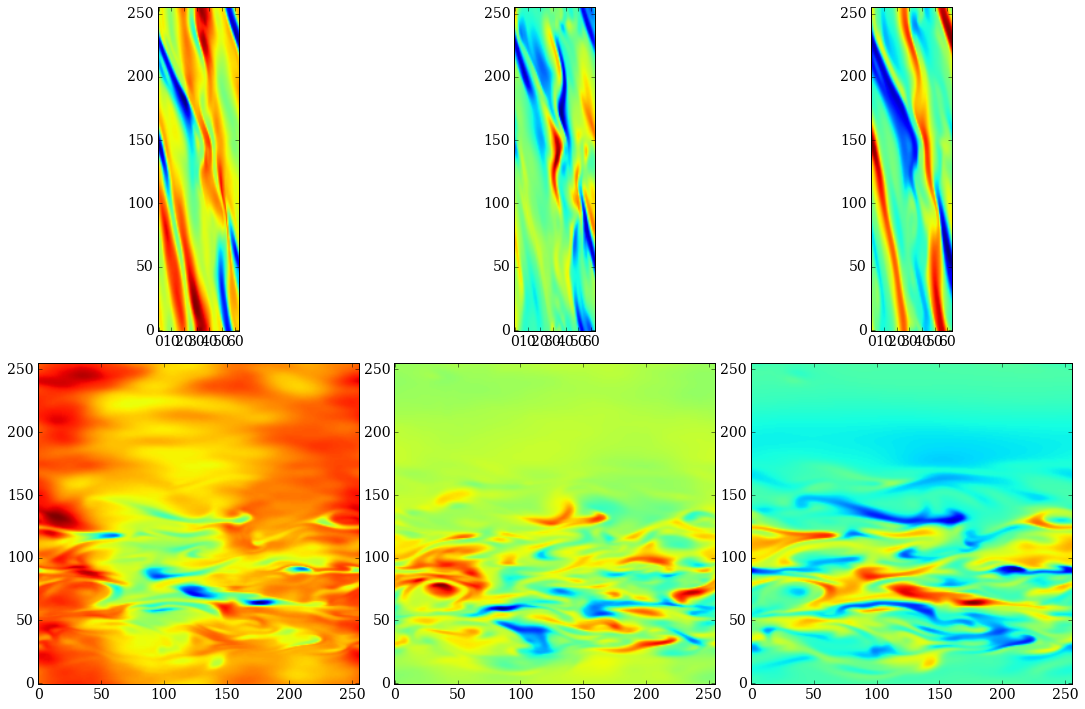

In [6]:
nframe = 2
nplot  = 3
cnt = 1
matplotlib.rcParams['figure.figsize'] = (15, 15.0*nframe/nplot)

plt.subplot(nframe,nplot,cnt)
plt.imshow(data['density'][128,:,:],origin='lower')

cnt+=1
plt.subplot(nframe,nplot,cnt)
vy = data['momentum'][:,:,:,1]/data['density']
plt.imshow(vy[128,:,:],origin='lower')

cnt+=1
plt.subplot(nframe,nplot,cnt)
by = data['cell_centered_B'][:,:,:,1]
plt.imshow(by[128,:,:],origin='lower')

plt.tight_layout()
cnt+=1
plt.subplot(nframe,nplot,cnt)
plt.imshow(data['density'][:,:,30],origin='lower')

cnt+=1
plt.subplot(nframe,nplot,cnt)
plt.imshow(vy[:,:,30],origin='lower')

cnt+=1
plt.subplot(nframe,nplot,cnt)
plt.imshow(by[:,:,30],origin='lower')

plt.tight_layout()

# 2. Now test the flood fill algorithm

##  2.1. test local exterme finder
### seems good , which in this case, using 2d/3d density, picks up the local minimum in a fast and reliable way

/u/jmshi/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


(25, 125)

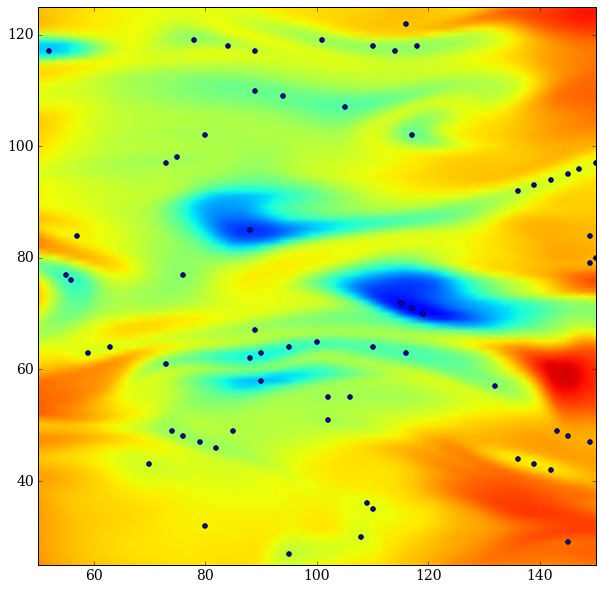

In [7]:
import numpy as np
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

def detect_local_minima(arr):
    # http://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),1)
    # apply the local minimum filter; all locations of minimum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_minima = local_min - eroded_background
    return np.where(detected_minima)   

arr = np.copy(data['density'][:,:,32])
loc = detect_local_minima(arr)
plt.imshow(arr,origin='lower')
plt.scatter(loc[1],loc[0])
plt.xlim(50,150)
plt.ylim(25,125)


## 2.2 test local maxima finder: it seems to work

In [8]:
import numpy as np
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

def detect_local_maxima(arr):
    # http://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),1)
    # apply the local maximum filter; all locations of maximum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#maximum_filter
    local_max = (filters.maximum_filter(arr, footprint=neighborhood)==arr)
    # local_max is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_maxima = local_max - eroded_background
    return np.where(detected_maxima)   


# of local maxima=  (167,)
[[ 0.98571903  0.98700029  0.98482698]
 [ 0.98561251  0.98707539  0.98484975]
 [ 0.98547804  0.98706394  0.98478693]
 [ 0.9853608   0.9869768   0.98472363]
 [ 0.98553336  0.98703068  0.98461014]
 [ 0.9857716   0.98704791  0.98446965]
 [ 0.98600072  0.98707956  0.98434871]
 [ 0.98608226  0.98703563  0.98427486]]
[59 61 78]


/u/jmshi/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


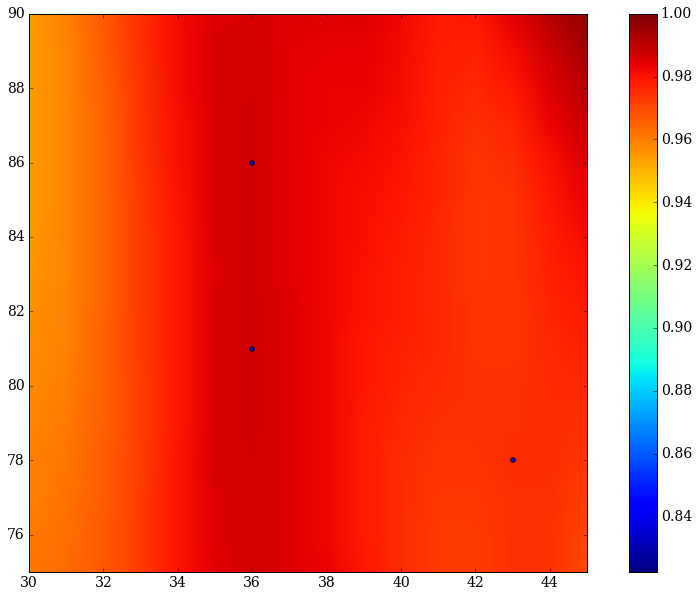

In [9]:
arr = np.copy(data['density'][128,:,:])
loc = detect_local_maxima(arr)
#x1,x2 = np.meshgrid(y,x)
#plt.pcolor(x1,x2,arr,cmap='RdBu',vmin=np.min(arr),vmax=np.max(arr))
plt.imshow(arr,origin='lower',vmax=1.0)
plt.colorbar()
plt.scatter(loc[1],loc[0])
print '# of local maxima= ',loc[0].shape
#plt.axis([0, 10, 70, 80])
plt.axis([30,45,75,90])
print arr[80:88,35:38]
#plt.imshow(arr[156:160,138:142],origin='lower')
print loc[0][loc[1]==43] # pick up the right lower point

## 2.3 test flood fill algorithm using stack with west/east loop to save the overhead

In [10]:
from test_floodfill import flood_fill_westack
d2d = np.copy(data['density'][50:55,100:105,0])
d2d[0,0]=1.2
d2d[1,0]=1.2
print np.min(d2d)
print np.max(d2d)
print d2d
print

loc_max = detect_local_maxima(d2d)
print loc_max

adict=flood_fill_westack(d2d,0,2,1.0)

print adict



0.997174561024
1.2
[[ 1.2         0.99935842  1.00010884  1.00097656  1.00198352]
 [ 1.2         0.99811208  0.99861324  0.9993729   1.00032318]
 [ 0.99717456  0.99746644  0.99811947  0.99910069  1.00015628]
 [ 0.99733073  0.99791843  0.998734    0.99978817  1.00101817]
 [ 0.99878192  0.99963701  1.00069892  1.00193381  1.00318885]]

(array([0, 0, 1, 4]), array([0, 4, 0, 4]))
{(4, 4): 1.0031888484954834, (1, 4): 1.0003231763839722, (0, 2): 1.0001088380813599, (4, 3): 1.0019338130950928, (0, 4): 1.0019835233688354, (4, 2): 1.0006989240646362, (0, 3): 1.0009765625, (3, 4): 1.0010181665420532, (2, 4): 1.0001562833786011}


/u/jmshi/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


## 2.4 test floodfill_2d modified to search current sheet in 2d

In [11]:
from test_floodfill import flood_fill_2d
d2d = np.copy(data['density'][50:55,100:105,0])
d2d[0,0]=1.2
d2d[1,0]=1.2
print np.min(d2d)
print np.max(d2d)
print d2d
print

0.997174561024
1.2
[[ 1.2         0.99935842  1.00010884  1.00097656  1.00198352]
 [ 1.2         0.99811208  0.99861324  0.9993729   1.00032318]
 [ 0.99717456  0.99746644  0.99811947  0.99910069  1.00015628]
 [ 0.99733073  0.99791843  0.998734    0.99978817  1.00101817]
 [ 0.99878192  0.99963701  1.00069892  1.00193381  1.00318885]]



## 2.4.1 find local maxima as input (in order to find all current sheets)

In [12]:
loc_max = detect_local_maxima(d2d)
npts = loc_max[0].shape
print npts[0]

4


/u/jmshi/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


## 2.4.2 now call flood_fill_2d on each local maxima and save the current sheet (dictionary) in jlist.

In [13]:
jlist = []
image = np.copy(d2d)
for i in range(0,npts[0]):
    (s,t) = (loc_max[0][i],loc_max[1][i])
    flood_fill_2d(image,s,t,1.0,jlist)
print jlist
print d2d
print
print image

initial cell is below color =  1.0
initial cell is below color =  1.0
[{(1, 0): 1.2, (0, 0): 1.2}, {(4, 4): 1.0031888484954834, (1, 4): 1.0003231763839722, (0, 2): 1.0001088380813599, (4, 3): 1.0019338130950928, (0, 4): 1.0019835233688354, (4, 2): 1.0006989240646362, (0, 3): 1.0009765625, (3, 4): 1.0010181665420532, (2, 4): 1.0001562833786011}]
[[ 1.2         0.99935842  1.00010884  1.00097656  1.00198352]
 [ 1.2         0.99811208  0.99861324  0.9993729   1.00032318]
 [ 0.99717456  0.99746644  0.99811947  0.99910069  1.00015628]
 [ 0.99733073  0.99791843  0.998734    0.99978817  1.00101817]
 [ 0.99878192  0.99963701  1.00069892  1.00193381  1.00318885]]

[[ 0.          0.99935842  0.          0.          0.        ]
 [ 0.          0.99811208  0.99861324  0.9993729   0.        ]
 [ 0.99717456  0.99746644  0.99811947  0.99910069  0.        ]
 [ 0.99733073  0.99791843  0.998734    0.99978817  0.        ]
 [ 0.99878192  0.99963701  0.          0.          0.        ]]


## 2.4.3 now measure how efficient it is for 2d arrays

In [14]:
d2d = np.copy(data['density'][:,:,0])
loc_max = detect_local_maxima(d2d)
npts=loc_max[0].shape
npts[0]

/u/jmshi/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


352

In [15]:
import time
from test_floodfill import flood_fill_2d

tstart = time.time()
jlist = []
image = np.copy(d2d)
for i in range(0,npts[0]):
    (s,t) = (loc_max[0][i],loc_max[1][i])
    flood_fill_2d(image,s,t,1.0,jlist)
tend = time.time()
print 'time cost = ',tend-tstart
#print jlist

initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is below color =  1.0
initial cell is belo

the time cost for searching current sheets in 256x256 is  1.14474701881 second
there are  29  current sheets in total
the sorted sheet size:
8479
6555
5380
981
973
909
765
457
215
113
106
103
73
60
58
41
28
28
10
9
9
7
5
2
2
2
2
2
1


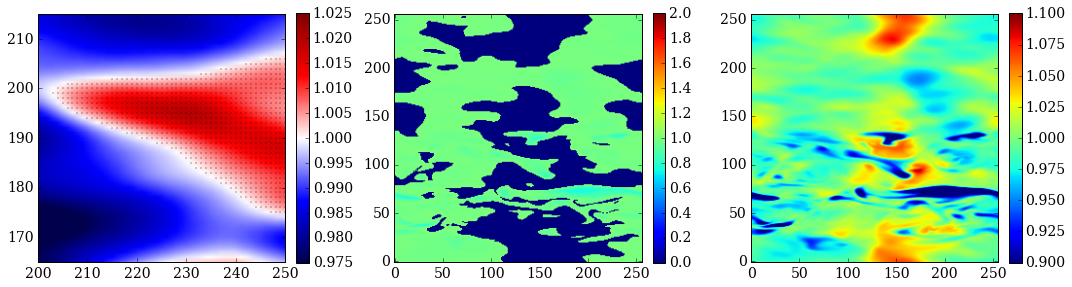

In [16]:
print 'the time cost for searching current sheets in 256x256 is ', tend-tstart, 'second'
print 'there are ',len(jlist),' current sheets in total'
print 'the sorted sheet size:'
jlist_sorted = sorted(jlist,key= lambda sheet: len(sheet))
for i in range(0,len(jlist_sorted)):
    print len(jlist_sorted[len(jlist)-i-1])
nframe = 1
nplot  = 3
matplotlib.rcParams['figure.figsize'] = (15, 15.0*nframe/nplot)
fraction=0.046;pad=0.04

plt.subplot(1,3,1)
plt.imshow(d2d,origin='lower',cmap='seismic',vmin=0.975,vmax=1.025)
plt.colorbar(fraction=fraction,pad=pad)
location=list(jlist[23].keys())
x1=[]
x2=[]
for (s,t) in location:
    x1.append(s)
    x2.append(t)
plt.scatter(x2,x1,s=0.5,alpha=0.3)
plt.xlim(200,250)
plt.ylim(165,215)


plt.subplot(1,3,2)
plt.imshow(image,origin='lower',vmin=0,vmax=2)
plt.colorbar(fraction=fraction,pad=pad)

plt.subplot(1,3,3)
plt.imshow(d2d,origin='lower',vmin=0.9,vmax=1.1)
plt.colorbar(fraction=fraction,pad=pad)

plt.tight_layout()
plt.show()

##  2.4.4 Now test the method with ndimage.measurements

there are  29  current sheets in total


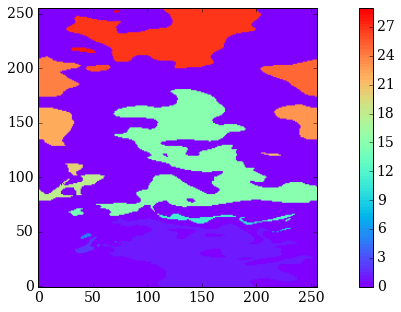

In [17]:
import numpy as np
import scipy.ndimage.measurements as measurements
import scipy.ndimage.morphology as morphology
from discrete_cmap import discrete_cmap
#import discrete_cmap

s=morphology.generate_binary_structure(2,1)
d2d = np.copy(data['density'][:,:,0])
d2d[d2d < 1.0] = 0.
labeled_array, num_features = measurements.label(d2d, structure=s)
print 'there are ', num_features, ' current sheets in total'
plt.imshow(labeled_array,cmap=discrete_cmap(90,'rainbow'),origin='lower')
plt.colorbar()

## 2.5 could we use the ndimage.measurements for 3d?? 
###  first get the labeled array for all current sheets and compare with previous 2d results: seems OK

107


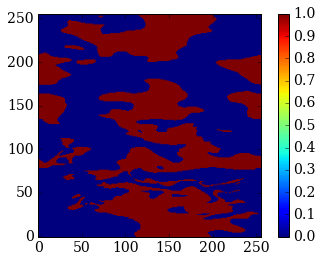

In [3]:
import numpy as np
import scipy.ndimage.measurements as measurements
import scipy.ndimage.morphology as morphology
from discrete_cmap import discrete_cmap
#import discrete_cmap

s=morphology.generate_binary_structure(3,1)
d3d = np.copy(data['density'])
d3d[d3d < 1.0] = 0.
labeled_array, num_features = measurements.label(d3d, structure=s)

#plt.imshow(labeled_array[:,:,0],cmap=discrete_cmap(90,'rainbow'),origin='lower')
labeled_array_norm = np.copy(labeled_array)
labeled_array_norm[labeled_array_norm >=1] = 1.0
plt.imshow(labeled_array_norm[:,:,0],origin='lower')
plt.colorbar()

print num_features

### we can then construct the current sheet list using the labeled array and original 3d data array
### we can pickle the sorted jlist for later usage

In [5]:
print 'there are ', num_features, ' current sheets in total'
# construct current sheet list based on the label_array
jlist = []
for i in range(1,num_features+1):
  jsheet = {}
  for loc in (np.argwhere(labeled_array == i)):
    jsheet[(loc[0],loc[1],loc[2])] = data['density'][loc[0],loc[1],loc[2]]
  if jsheet: 
    jlist.append(jsheet)

# sort the list based on length
jlist_sorted = sorted(jlist,key= lambda sheet: -len(sheet))
#for i in range(0,len(jlist_sorted)):
    #print len(jlist_sorted[len(jlist)-i-1])
#    print len(jlist_sorted[i])
print [len(jlist_sorted[i]) for i in range(0,5)]

# store dict list with pickle
import cPickle as pickle
pickle.dump(jlist_sorted, open( "test_jlist.p", "wb" ),2)

there are  107  current sheets in total
[2148556, 10128, 3199, 947, 490]


### then try to visualize one current sheet with trisurface

In [9]:
jlistp = pickle.load( open( "test_jlist.p", "rb" ) )

<IPython.core.display.Javascript object>


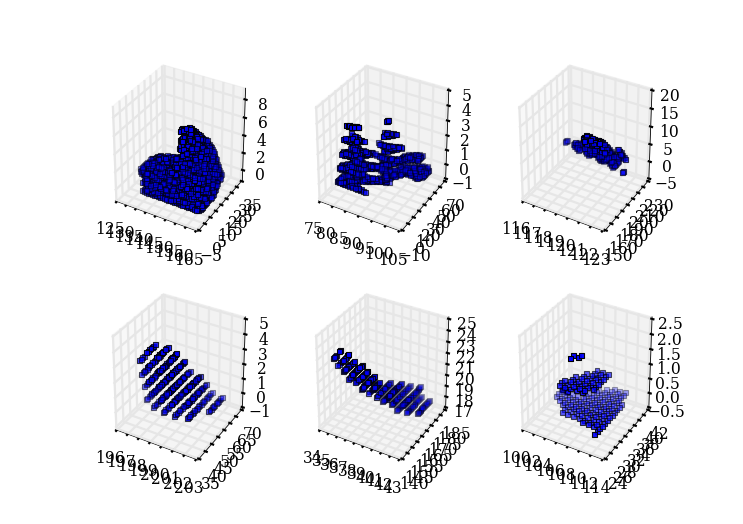

In [39]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
%matplotlib notebook
#show the first six sheets largest in size
nframe = 2
nplot  = 3
matplotlib.rcParams['figure.figsize'] = (15, 15.0*nframe/nplot)
fig = plt.figure()
fraction=0.046;pad=0.04

gs = gridspec.GridSpec(2, 3)
for i in range(2,8):
  locs = np.array(jlistp[i].keys())
  ax = fig.add_subplot(gs[i-2], projection='3d')
  ax.scatter(locs[:,0], locs[:,1], locs[:,2],marker='s')


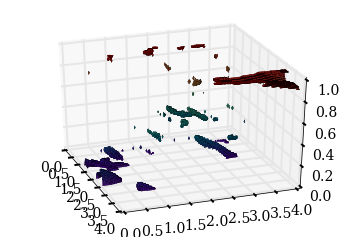

In [8]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
#from skimage.draw import ellipsoid

verts, faces = measure.marching_cubes(labeled_array, 2, spacing=(0.015625,0.015625,0.015625))

#fig = plt.figure(figsize=(10, 12))
#ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
#mesh = Poly3DCollection(verts[faces])
#ax.add_collection3d(mesh)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                cmap='rainbow', lw=0.2)
ax.azim= -20
#ax.set_xlabel("x-axis: a = 6 per ellipsoid")
#ax.set_ylabel("y-axis: b = 10")
#ax.set_zlabel("z-axis: c = 16")

#ax.set_xlim(0, 24)  # a = 6 (times two for 2nd ellipsoid)
#ax.set_ylim(0, 20)  # b = 10
#ax.set_zlim(0, 32)  # c = 16

#plt.show()

In [45]:
d3d = np.copy(data['density'])
loc_max = detect_local_maxima(d3d)
npts=loc_max[0].shape
npts[0]

/u/jmshi/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


8897

In [ ]:
import time
from test_floodfill import flood_fill_2d

tstart = time.time()
jlist = []
image = np.copy(d2d)
for i in range(0,npts[0]):
    (s,t) = (loc_max[0][i],loc_max[1][i])
    flood_fill_2d(image,s,t,1.0,jlist)
tend = time.time()
print 'time cost = ',tend-tstart
#print jlist

In [47]:


a=np.array([1,2,3,4])
a[a>=3]=1
print a,t

[1 2 1 1] [3 4]


In [ ]:
index=d2d <1
d2d[index]=0

print index[0]

print np.min(d2d)
print np.max(d2d)
ashape = d2d.shape
print ashape[0], ashape[1]
a=np.zeros([2,2])
a.shape

import time

tstart = time.time()
flood_fill(d2d,0,0,6,6,1.0)
tend = time.time()
print 'the time spend is ', tend-tstart
print d2d
print np.min(data['density'])
print np.max(data['density'])